# Preprocessing: H&E Stain Normalization

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/stain_normalization.ipynb)

This notebook gives examples of the stain deconvolution and normalization tools available in `PathML`.

H&E images are the result of applying two stains to a tissue sample: hematoxylin and eosin. Hematoxylin binds to the cell nuclei and colors them purple, while eosin binds to the cytoplasm and extracellular matrix, coloring them pink. In this context, stain normalization refers to the process of standardizing or normalizing the appearance of tissue samples across different slides or imaging systems. Stain deconvolution is the process of untangling these two superimposed stains from an H&E image.

Digital pathology images can vary for many reasons, including:

- variation in stain intensity due to inconsistencies of technicians while applying stains to specimens
- variation in image qualities due to differences in slide scanners
- variation due to differences in lighting conditions when slide is scanned
- etc.

For these reasons, stain normalization is a crucial part of any computational pathology workflow.

Stain deconvolution can also be used in other ways, due to the different biological properties of the stains. For example, we can apply stain separation and use the hematoxylin channel as input to a nucleus detection algorithm (see nucleus detection example notebook).

`PathML` comes with two stain normalization algorithms out of the box: the Macenko and Vahadane methods (Macenko et al. 2009; Vahadane et al. 2016). As more stain deconvolution methods are incorporated into `PathML`, they will be added here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

from pathml.core import HESlide
from pathml.preprocessing import StainNormalizationHE

In [2]:
fontsize = 20

### Data

This example notebook uses publicly available images from:

1) OpenSlide: Download `CMU-1-Small-Region.svs.tiff` from [here](http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/).
2) BRACS: Download `target.png` from [here](https://github.com/histocartography/hact-net/blob/main/data/target.png).

You can also change the filepaths to use any whole-slide images that you have locally.

We will pull out some tiles to use as an example. The **source** image is what you want to normalize, and the **target** is the high-quality image which provides the reference for normalizing. In many worflows, you have multiple **source** images that you want to normalize with the help of one representative **target** image. 

In [3]:
source_wsi = HESlide("../data/CMU-1-Small-Region.svs.tiff")
source_region = source_wsi.slide.extract_region(location=(0, 0), size=(2000, 2000))
source_region = np.squeeze(source_region)

target_wsi = HESlide("../data/target.png")
target_region = target_wsi.slide.extract_region(location=(0, 0), size=(500, 500))
target_region = np.squeeze(target_region)

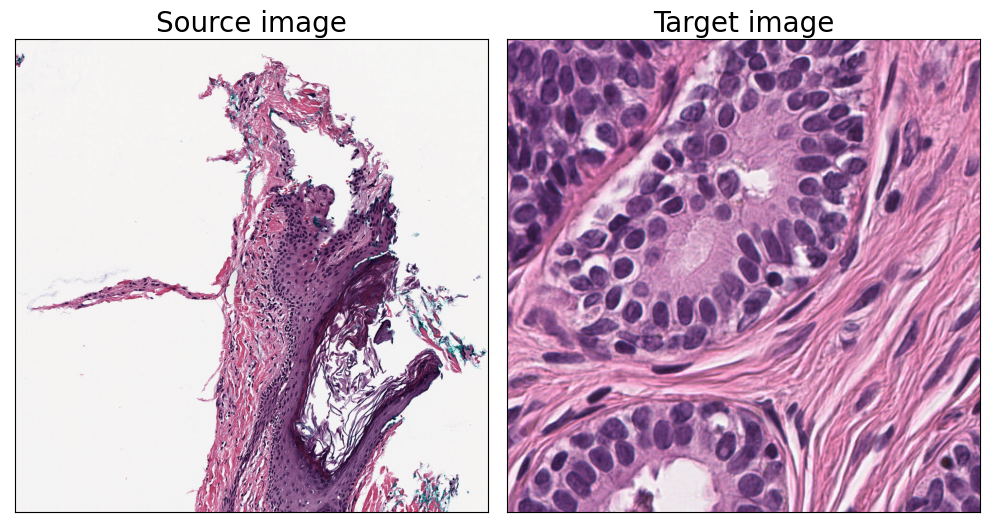

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7.5))

ax[0].imshow(source_region)
ax[0].set_title("Source image", fontsize=fontsize)

ax[1].imshow(target_region)
ax[1].set_title("Target image", fontsize=fontsize)

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## Stain normalization

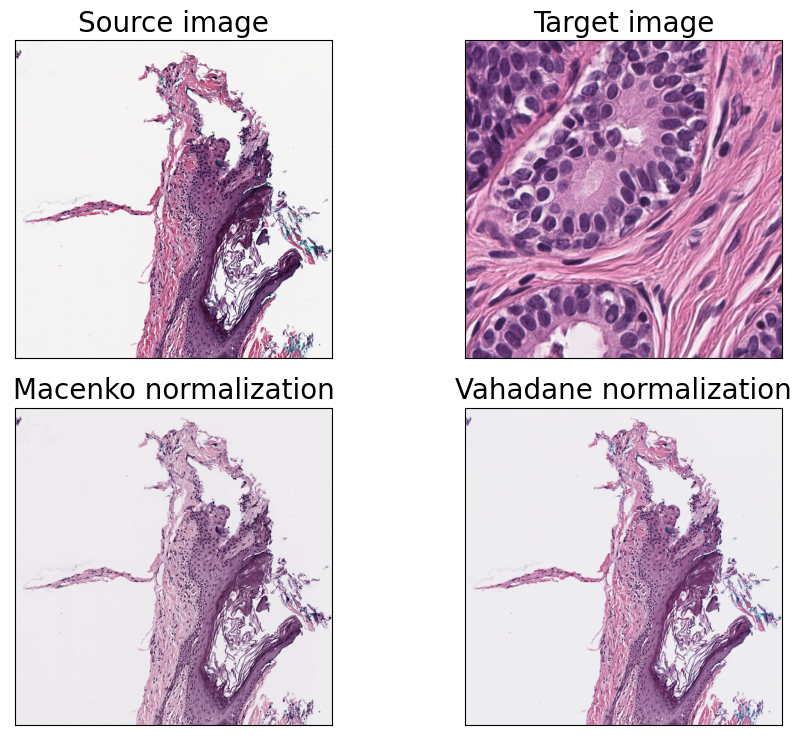

In [5]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(10, 7.5))
axarr[0, 0].imshow(source_region)
axarr[0, 0].set_title("Source image", fontsize=fontsize)

axarr[0, 1].imshow(target_region)
axarr[0, 1].set_title("Target image", fontsize=fontsize)

for j, method in enumerate(["Macenko", "Vahadane"]):
    # initialize stain normalization object
    normalizer = StainNormalizationHE(
        target="normalize", stain_estimation_method=method
    )

    # fit to the target image
    normalizer.fit_to_reference(target_region)

    # apply on example source image
    im = normalizer.F(source_region)

    # plot results
    ax = axarr[1, j]
    ax.imshow(im)
    ax.set_title(f"{method} normalization", fontsize=fontsize)

for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## Stain Deconvolution

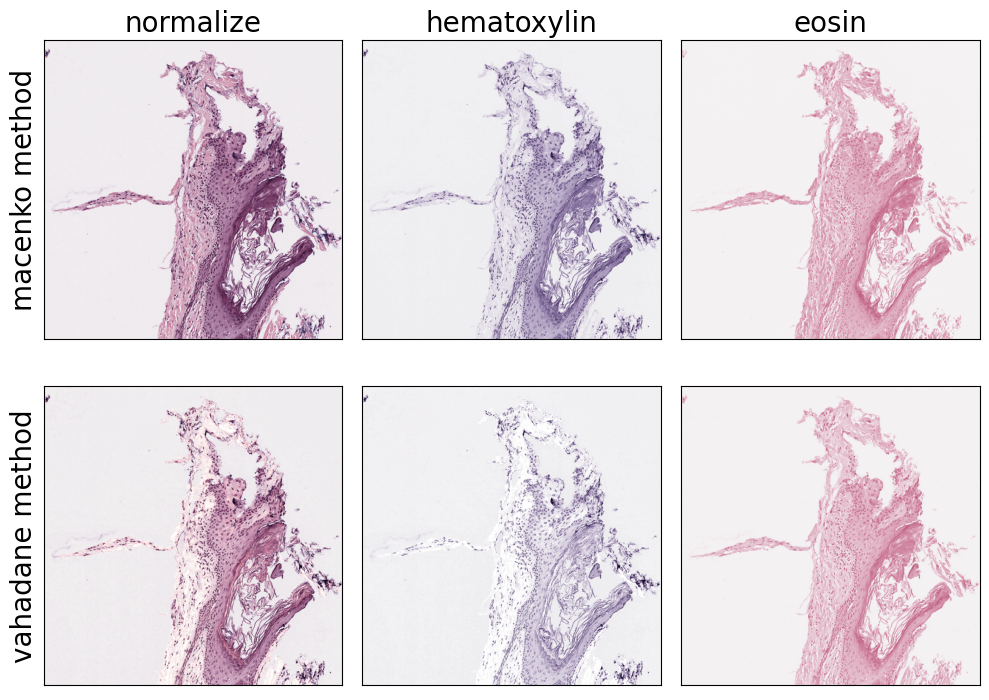

In [6]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))

for i, method in enumerate(["macenko", "vahadane"]):
    for j, target in enumerate(["normalize", "hematoxylin", "eosin"]):
        # initialize stain normalization object
        normalizer = StainNormalizationHE(target=target, stain_estimation_method=method)
        # apply on example image
        im = normalizer.F(source_region)

        # plot results
        ax = axarr[i, j]
        ax.imshow(im)
        if j == 0:
            ax.set_ylabel(f"{method} method", fontsize=fontsize)
        if i == 0:
            ax.set_title(target, fontsize=fontsize)

for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## References

* Macenko, M., Niethammer, M., Marron, J.S., Borland, D., Woosley, J.T., Guan, X., Schmitt, C. and Thomas, N.E., 2009, June. A method for normalizing histology slides for quantitative analysis. In 2009 IEEE International Symposium on Biomedical Imaging: From Nano to Macro (pp. 1107-1110). IEEE.
* Vahadane, A., Peng, T., Sethi, A., Albarqouni, S., Wang, L., Baust, M., Steiger, K., Schlitter, A.M., Esposito, I. and Navab, N., 2016. Structure-preserving color normalization and sparse stain separation for histological images. IEEE transactions on medical imaging, 35(8), pp.1962-1971.